In [1]:
import numpy as np 
import pandas as pd

In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate,GRU,Dropout,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.io import FixedLenFeature
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, normalize

In [3]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


In [4]:
try: 
     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
     strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
     strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.20.231.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.20.231.202:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


In [5]:

AUTO = tf.data.experimental.AUTOTUNE

In [6]:
data_train = pd.read_csv('higgs-boson/training.csv')
data_test = pd.read_csv('higgs-boson/test.csv')

print(data_train.shape,data_test.shape)

(250000, 33) (550000, 31)


In [8]:
list(set(data_train.columns ) - set(data_test.columns))

['Label', 'Weight']

In [9]:
data_train.drop(['Weight'], axis=1,inplace=True)

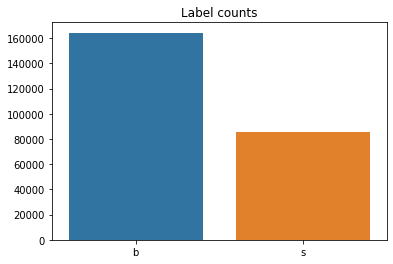

In [10]:
sns.barplot(x = data_train['Label'].value_counts().index, y = data_train['Label'].value_counts().values)
plt.title('Label counts')
plt.show()

In [11]:
enc = LabelEncoder()

data_train['Label'] = enc.fit_transform(data_train['Label'])
data_train.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,1
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,0.879,1.414,-999.0,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,0
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,3.776,1.414,-999.0,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,2.354,-1.285,-999.0,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,0
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,1.056,-1.385,-999.0,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,0


In [12]:
data_train.set_index(['EventId'],inplace = True)
data_test.set_index(['EventId'],inplace = True)

In [13]:
X = data_train.drop(['Label'], axis=1)
y = data_train['Label'].values

In [14]:
X = normalize(X)
data_test_nor = normalize(data_test)

In [15]:
split_data=StratifiedShuffleSplit(n_splits=1,random_state=12)

for train,test in split_data.split(X,y):     #this will splits the index
    X_train_1 = X[train]
    y_train_1 = y[train]
    X_test_1 = X[test]
    y_test_1 = y[test]

In [16]:
X_train_1 = np.reshape(X_train_1, (X_train_1.shape[0],X_train_1.shape[1],1))
X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0],X_test_1.shape[1],1))

In [17]:
X_train_1.shape[2]

1

In [18]:
def make_Gru_model(train_x,train_y,x_test,y_test):
    inp = Input(shape=(train_x.shape[1],train_x.shape[2]))
    rnn_1st_layer = GRU(units = 60,return_sequences=True,recurrent_dropout=0.1)(inp)
    rnn_2nd_layer = GRU(units = 60,recurrent_dropout=0.1)(rnn_1st_layer)
    dense_layer = Dense(128)(rnn_2nd_layer)
    drop_out = Dropout(0.25)(dense_layer)
    output = Dense(1, activation= LeakyReLU(alpha=0.1),name="class")(drop_out)
    model = Model(inp, output)
    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.6),
                 EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='results_model_GRU.h5', monitor='val_loss', save_best_only=True)]
    model.summary()
    model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam",metrics=['accuracy'])
    history = model.fit(train_x, train_y, 
          epochs = 10, 
          batch_size = 128, 
          validation_data=(x_test,  y_test), 
          callbacks=callbacks)
    y_pred = model.predict(x_test).ravel()
    return history,model

In [19]:
def plot_Loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

In [20]:
def plot_Accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

In [21]:

def Save_Result_To_Csv(model,model_name,csv_file):
    test_1 = np.reshape(test_data_nor, (test_data_nor.shape[0],test_data_nor.shape[1],1))
    model.load_weights(model_name)
    prediction = model.predict(test_1)
    prediction =  np.where(prediction > 0.5, 1, 0)
    prediction = pd.Series(prediction[:,0])
    save_file = pd.read_csv('/higgs-boson/results.zip')
    test_predict = pd.DataFrame({"EventId":sub['EventId'],"RankOrder":sub['RankOrder'],"Class":prediction})
    test_predict['Class'] = test_predict['Class'].replace(1,'s')
    test_predict['Class'] = test_predict['Class'].replace(0,'b')
    test_predict.to_csv(csv_file,index=False)

In [22]:
history_GRU,Gru_model = make_Gru_model(X_train_1,y_train_1,X_test_1,y_test_1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
gru (GRU)                    (None, 30, 60)            11340     
_________________________________________________________________
gru_1 (GRU)                  (None, 60)                21960     
_________________________________________________________________
dense (Dense)                (None, 128)               7808      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
class (Dense)                (None, 1)                 129       
Total params: 41,237
Trainable params: 41,237
Non-trainable params: 0
_________________________________________________________

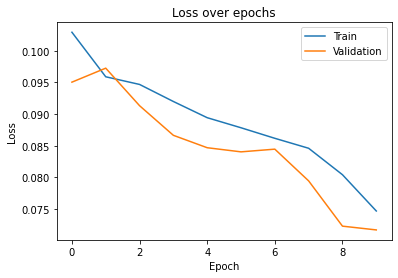

In [23]:
plot_Loss(history_GRU)

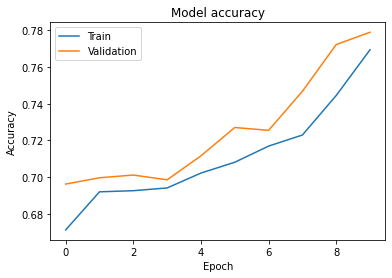

In [24]:
plot_Accuracy(history_GRU)